In [1]:
using PerlaTonettiWaugh, Parameters, Plots, DataFrames, Optim

In [2]:
params_base = parameter_defaults()
d_0 = params_base.d_0
d_T = params_base.d_T
settings = settings_defaults();

In [3]:
welfare_objective(vals; params) = -PerlaTonettiWaugh.welfare(vals, params).U_bar

welfare_objective (generic function with 1 method)

In [4]:
df = DataFrame()
d_grid = range(d_0, d_T, length = 100) # we see instability around d_0 

for d in d_grid
    params = merge(params_base, (d = d,))

    sol_competitive = stationary_numerical(params, settings)
    init_x = [sol_competitive.g, sol_competitive.z_hat, sol_competitive.Ω]

    sol_planner = try optimize(x -> welfare_objective([x, sol_competitive.z_hat, sol_competitive.Ω], params = params), 0.005, 0.16)
    catch e 
        continue # just skip it if it doesn't work
    end
    
    g_planner = Optim.minimizer(sol_planner)
    U_bar_planner = -Optim.minimum(sol_planner)
    U_bar_competitive = sol_competitive.U_bar
    
    consumption_equivalent = PerlaTonettiWaugh.consumption_equivalent(U_bar_planner, U_bar_competitive, params)
    
    push!(df, (d = d,
                g_rat = g_planner/sol_competitive.g, 
                g_planner = g_planner,
                g_competitive = sol_competitive.g,
                consumption_equivalent = consumption_equivalent,
                U_bar_planner = U_bar_planner,
                U_bar_competitive = U_bar_competitive,
                U_bar_rat = U_bar_planner/sol_competitive.U_bar,
            ))
end

size(df) # check for emptiness

(100, 8)

In [5]:
p_g_ratio = plot(df.d, df.g_rat, xlabel = "d", ylabel = "g ratio", title = "growth rates ratio (planner/competitive)", legend = false);
p_g_levels = plot(xlabel = "d", ylabel = "g", title = "growth rate levels", legend = :topleft)
plot!(p_g_levels, df.d, df.g_competitive, label = "competitive eq.")
plot!(p_g_levels, df.d, df.g_planner, label = "planner");

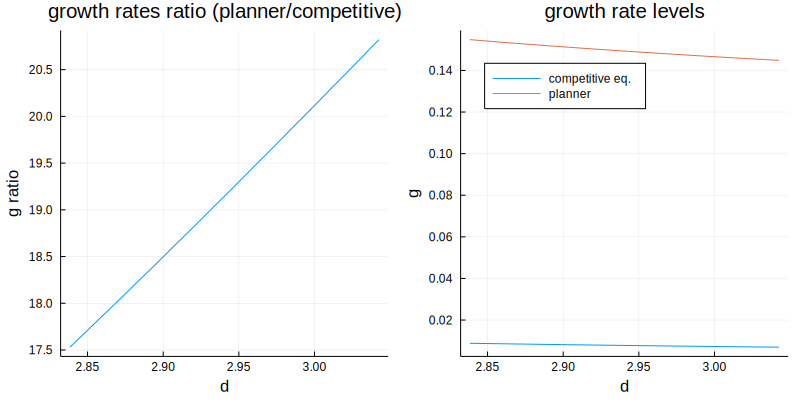

In [6]:
plot(p_g_ratio, p_g_levels,size = (800, 400))

In [7]:
p_consumption_equivalent = plot(df.d, df.consumption_equivalent, xlabel = "d", title = "Consumption Equivalent", legend = false)
p_welfare_ratio = plot(df.d, df.U_bar_rat, xlabel = "d", ylabel = "U_bar ratio", title = "Welfare ratio (planner/equilibrium)", legend = false);

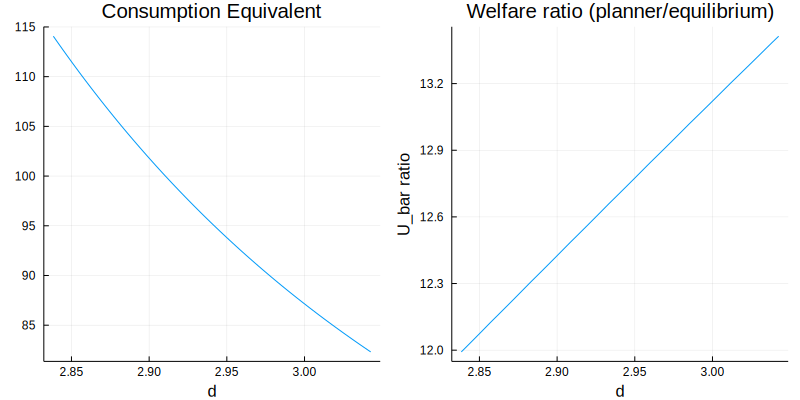

In [8]:
plot(p_consumption_equivalent, p_welfare_ratio, size = (800, 400))

In [9]:
growth_old = df.g_competitive;

## $\gamma$ = 2

In [10]:
params_base = parameter_defaults(γ = 2, χ = 0.1895, ζ = 1.045)
d_0 = params_base.d_0
d_T = params_base.d_T
settings = settings_defaults();

In [11]:
welfare_objective(vals; params) = -PerlaTonettiWaugh.welfare(vals, params).U_bar

welfare_objective (generic function with 1 method)

In [12]:
df = DataFrame()
d_grid = range(d_0, d_T, length = 100) # we see instability around d_0 

for d in d_grid
    params = merge(params_base, (d = d,))

    sol_competitive = stationary_numerical(params, settings)
    init_x = [sol_competitive.g, sol_competitive.z_hat, sol_competitive.Ω]

    sol_planner = try optimize(x -> welfare_objective([x, sol_competitive.z_hat, sol_competitive.Ω], params = params), 0.005, 0.16)
    catch e 
        continue # just skip it if it doesn't work
    end
    
    g_planner = Optim.minimizer(sol_planner)
    U_bar_planner = -Optim.minimum(sol_planner)
    U_bar_competitive = sol_competitive.U_bar
    
    consumption_equivalent = PerlaTonettiWaugh.consumption_equivalent(U_bar_planner, U_bar_competitive, params)
    
    push!(df, (d = d,
                g_rat = g_planner/sol_competitive.g, 
                g_planner = g_planner,
                g_competitive = sol_competitive.g,
                consumption_equivalent = consumption_equivalent,
                U_bar_planner = U_bar_planner,
                U_bar_competitive = U_bar_competitive,
                U_bar_rat = U_bar_planner/sol_competitive.U_bar,
            ))
end

size(df) # check for emptiness

(100, 8)

In [13]:
p_g_ratio = plot(df.d, df.g_rat, xlabel = "d", ylabel = "g ratio", title = "growth rates ratio (planner/competitive)", legend = false);
p_g_levels = plot(xlabel = "d", ylabel = "g", title = "growth rate levels", legend = :right)
plot!(p_g_levels, df.d, df.g_competitive, label = "competitive eq.")
plot!(p_g_levels, df.d, df.g_planner, label = "planner");

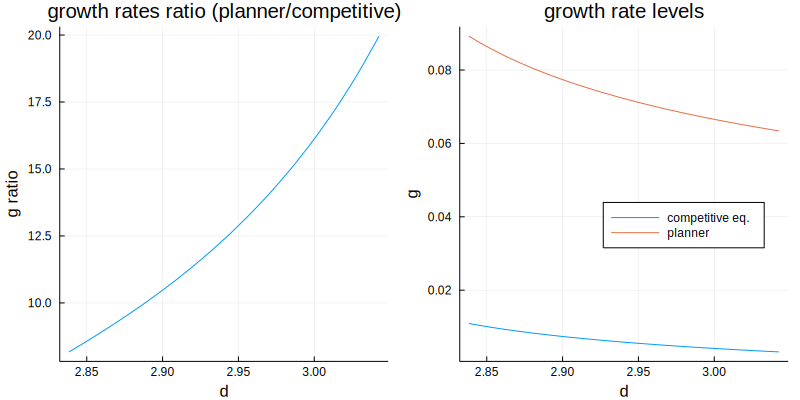

In [14]:
plot(p_g_ratio, p_g_levels,size = (800, 400))

In [15]:
p_consumption_equivalent = plot(df.d, df.consumption_equivalent, xlabel = "d", title = "Consumption Equivalent", legend = false)
p_welfare_ratio = plot(df.d, df.U_bar_rat, xlabel = "d", ylabel = "U_bar ratio", title = "Welfare ratio (planner/equilibrium)", legend = false);

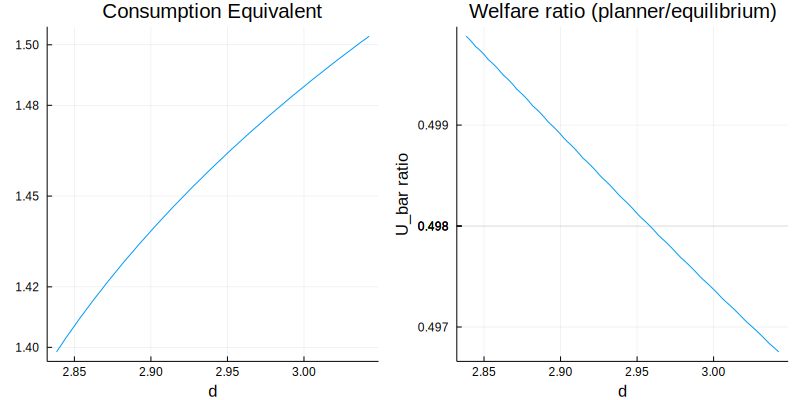

In [16]:
plot(p_consumption_equivalent, p_welfare_ratio, size = (800, 400))

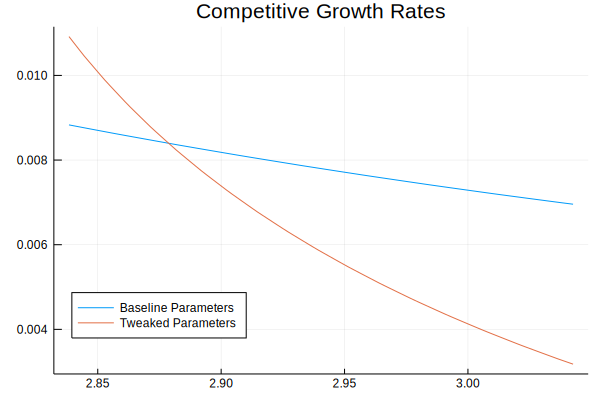

In [17]:
plot(df.d, growth_old, title = "Competitive Growth Rates", label = "Baseline Parameters");
plot!(df.d, df.g_competitive, label = "Tweaked Parameters", legend = :bottomleft)